<a href="https://colab.research.google.com/github/napongps/Muaythai-comparison/blob/main/Muaythai_comparison%5BFor%20Export%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
def in_colab():
    from IPython.core import getipython
    return 'google.colab' in str(getipython.get_ipython())

in_colab()

False

In [75]:
if in_colab():
    !pip install mediapipe
    !pip install opencv-python
    !pip install pyshine
    !pip install plotly
    !pip install wget
# else:
#     %autosave 60
#     %pip install --upgrade ipykernel

In [76]:
import os
import math
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pyshine as ps
from glob import glob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [77]:
if in_colab():
    from google.colab import drive
    drive.mount('/content/drive')

    # !mkdir Resources
    # !mkdir 'Resources/Video_เพื่อน'
    # !mkdir 'Resources/Different camera angle'

    # %cp -r '/content/drive/MyDrive/Resources/Video_เพื่อน/landmarks' ./
    # os.rename('landmarks', '/content/Resources/Video_เพื่อน/landmarks')
    # %cp -r '/content/drive/MyDrive/Resources/Different camera angle/landmarks' ./
    # os.rename('landmarks', '/content/Resources/Different camera angle/landmarks')
    # %cp -r '/content/drive/MyDrive/Resources/weight_config_angle_list.csv' ./
    # os.rename('/content/weight_config_angle_list.csv', '/content/Resources/weight_config_angle_list.csv')
    # %cp -r '/content/drive/MyDrive/Resources/weight_config_cosine_list.csv' ./
    # os.rename('/content/weight_config_cosine_list.csv', '/content/Resources/weight_config_cosine_list.csv')

In [78]:
mp_pose = mp.solutions.pose

pose_video = mp_pose.Pose(static_image_mode=False,
                          min_detection_confidence=0.5, model_complexity=2)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [79]:
if in_colab():
    resource = '/content/drive/MyDrive/Resources'
    friends_video = resource+'/Video_เพื่อน'
    diff_angle = resource+'/Different camera angle'
    slash = '/'
    desktop = '/content'
else:
    resource = f'C:\\Users\\{os.getlogin()}\Desktop\\resource'
    friends_video = f'C:\\Users\\{os.getlogin()}\\Desktop\\resource\\Video_เพื่อน'
    diff_angle = f'C:\\Users\\{os.getlogin()}\\Desktop\\resource\\Different camera angle'
    slash = '\\'
    desktop = f'C:\\Users\\{os.getlogin()}\Desktop'

# Landmark detection

In [80]:
def detectPose(frame: np.array):
    """
    Input:
        frame = numpy array of frame that is extracted by cv2

    Output:
        output_image = image that has skeleton in that frame
        norm_landmarks = camera coordinate every keypoint in that frame
        norm_world_landmarks = world coordinate every keypoint in that frame
    """

    output_image = frame.copy()
    output_image.flags.writeable = False
    result = pose_video.process(output_image)

    output_image.flags.writeable = True
    if result.pose_landmarks:
        norm_landmarks = result.pose_landmarks.landmark  # camera coordinate
        norm_world_landmarks = result.pose_world_landmarks.landmark  # world coordinate

        # เอา landmark ที่ไม่ได้ใช้ออก ใบหน้า นิ้วต่างๆ
        exclude_lndmk = list(range(11))
        exclude_lndmk.extend([29, 30, 17, 18, 21, 22])

        for i in exclude_lndmk:
            norm_landmarks[i].visibility = 0

        mp_drawing.draw_landmarks(image=output_image,
                                  landmark_list=result.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    return output_image, norm_landmarks, norm_world_landmarks

In [81]:
def formatJoint(landmarks_obj: list):
    """
    Input:
        landmarks_obj = result landmarks that get from mediapipe

    Output:
        list of x,z,y coordinate for every keypoint eg. [[x1, y1, z1], [x2, y1, z1], ..., [x33, y33, z33]]
    """

    return list(map(lambda ladk: [ladk.x, ladk.y, ladk.z], landmarks_obj))

In [82]:
def landmark_detection(path_vid: str):
    """
    Input:
        path_vid = path of video

    Output:
        cam_ladk = numpy array that contain camera coordinate of all keypoint in every frame of the video
        world_ladk = numpy array that contain world coordinate of all keypoint in every frame of the video
        all_frame = list that contain all skeletal frame in the video
    """

    video = cv2.VideoCapture(path_vid)

    all_frame = []
    cam_ladk = []
    world_ladk = []
    count = 0

    while video.isOpened():

        ret, frame = video.read()

        if not ret:
            break

        # กรณีที่ mediapipe ไม่สามารถหา landmark ได้ detectPose จะเป็น Nonetype
        try:
            output_image, norm_landmarks, norm_world_landmarks = detectPose(
                frame)
        except:
            continue

        output_image = ps.putBText(output_image, "Frame: {}".format(count),
                                   text_offset_x=50, text_offset_y=50, vspace=10, hspace=10,
                                   font_scale=1, background_RGB=(0, 0, 0), text_RGB=(255, 250, 250))

        all_frame.append(output_image)
        cam_ladk.append(formatJoint(norm_landmarks))
        world_ladk.append(formatJoint(norm_world_landmarks))

        count += 1

    video.release()
    cv2.destroyAllWindows()
    return np.array(cam_ladk), np.array(world_ladk), all_frame

# Export files

In [83]:
def export_ladk(path_des: str):
    """
    Input:
        path_des = A path of folder that contains videos
    """
    ladk_dir = f"{desktop}{slash}landmarks_diff_angle"
    !rm -rf "{ladk_dir}
    !mkdir "{ladk_dir}"
    vid_list = glob(path_des+'/**/*.mp4')+glob(path_des+'/**/*.MOV')

    for vid in vid_list:
        movement_name = vid.split(slash)[-2]
        vid_name = vid.split(slash)[-1].replace('.mp4','').replace('.MOV','')

        if not os.path.isdir(f"{ladk_dir}/{movement_name}"):
            !mkdir "{ladk_dir}{slash}{movement_name}"

        !mkdir "{ladk_dir}{slash}{movement_name}{slash}{vid_name}"

        cam_ladk, world_ladk, all_frame = landmark_detection(vid)

        dir = f'{ladk_dir}{slash}{movement_name}{slash}{vid_name}'
        with open(f"{dir}{slash}cam_{vid_name}", "wb") as fp:
            np.save(fp, cam_ladk)
        with open(f"{dir}{slash}world_{vid_name}", "wb") as fp:
            np.save(fp, world_ladk)
        with open(f"{dir}{slash}all_frame_{vid_name}", "wb") as fp:
            pickle.dump(all_frame, fp)

    # if os.path.isdir("{}/landmarks".format(path_des)):
    #     !rm -rf "{path_des}/landmarks"

    # !rsync -a -q "/content/landmarks" "{path_des}"

In [84]:
# export_ladk(friends_video)

In [85]:
# export_ladk(diff_angle)

# Import files

In [86]:
def import_file(path: str):
    """
    Input:
        path = path of video landmark

    Output:
        cam_ladk = numpy array that contain camera coordinate of all keypoint in every frame of the video
        world_ladk = numpy array that contain world coordinate of all keypoint in every frame of the video
        all_frame = list that contain all skeletal frame in the video
    """

    vid_name = path.split(slash)[-1]
    with open('{}{}cam_{}'.format(path, slash, vid_name), 'rb') as f:
        cam_ladk = np.load(f, allow_pickle=True)
    with open('{}{}world_{}'.format(path, slash, vid_name), 'rb') as f:
        world_ladk = np.load(f, allow_pickle=True)
    with open("{}{}all_frame_{}".format(path, slash, vid_name), "rb") as fp:
        all_frame = pickle.load(fp)

    return cam_ladk, world_ladk, all_frame

In [87]:
cam_ladk_test, world_ladk_test, all_frame_test = import_file(friends_video + "{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า".format(slash, slash, slash))
cam_ladk_test2, world_ladk_test2, all_frame_test2 = import_file(friends_video + "{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า_2".format(slash, slash, slash))

# Import weight

In [88]:
def gen_weight_csv(similarity_function):

    if "angle" in similarity_function.__name__.lower():

        cols = ['r_wrist', 'r_elbow', 'r_shoulder', 'r_hip', 'r_knee', 'r_ankle',
                'l_wrist', 'l_elbow', 'l_shoulder', 'l_hip', 'l_knee', 'l_ankle']

    elif "cosine" in similarity_function.__name__.lower():

        cols = ['R_findex_ankle', 'R_ankle_knee', 'R_knee_hip', 'R_hip_shoulder', 'R_index_wrist', 'R_wrist_elbow', 'R_elbow_shoulder',
                'L_findex_ankle', 'L_ankle_knee', 'L_knee_hip', 'L_hip_shoulder', 'L_index_wrist', 'L_wrist_elbow', 'L_elbow_shoulder',
                'lshoulder_rshoulder', 'lhip_rhip']
    weight_dict = dict.fromkeys(cols, 1)

    path = 'C:\\Users\\Gear\Desktop\\resource\\weight_config_{}.csv'

    if in_colab():
        path = 'weight_config_{}.csv'

    pd.DataFrame(weight_dict, index=[0]).to_csv(
        path.format(similarity_function.__name__.lower()))

In [89]:
def import_weight(weight_csv: str, vid_name: str):
    df = pd.read_csv(weight_csv, encoding='utf-8')
    return df[df['Name'] == vid_name].to_numpy()[0][1:]

In [90]:
weight_angle = import_weight(resource + '{}weight_config_angle_list.csv'.format(slash), 'default')
weight_cosine = import_weight(resource + '{}weight_config_cosine_list.csv'.format(slash), 'default')

In [91]:
weight_angle

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=object)

In [92]:
import_weight(resource + '{}weight_config_cosine_list.csv'.format(slash), 'เข่าตรงหลัง')

array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2], dtype=object)

# Comparison methods

## Mapping score function

C:\Users\Gear\AppData\Local\Temp\ipykernel_4444\2787851675.py:11: RuntimeWarning: divide by zero encountered in divide
  y = np.where((x >= 0) & (x <= 1), 1/(1+(x/(1-x))**-2), x)
C:\Users\Gear\AppData\Local\Temp\ipykernel_4444\2787851675.py:11: RuntimeWarning: divide by zero encountered in power
  y = np.where((x >= 0) & (x <= 1), 1/(1+(x/(1-x))**-2), x)


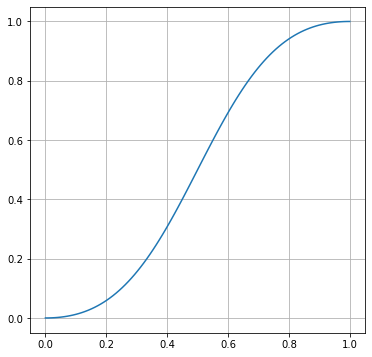

In [93]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 100)

# scaling here
# y = np.sign(x) * ((np.abs(x)) ** (3*1.4)) # formula = x^3z
# y = np.where(x>=0, np.where(x >= 0.5, np.cbrt(x), 5.65*x**3), np.cbrt(x))
# y = x**3
# y = np.cbrt(x)
y = np.where((x >= 0) & (x <= 1), 1/(1+(x/(1-x))**-2), x)

plt.figure(figsize=(6, 6))
# for i,j in zip(x,y):
#     print(i,j)
#     plt.annotate('({:.2f},{:.2f})'.format(i,j),xy=(i,j))
plt.plot(x, y)
plt.grid()
plt.show()

## Angle

### Extract function

In [94]:
def cal_norm_vec(point1: np.array, point2: np.array):

    vec = point2-point1
    vec_mag = np.linalg.norm(vec, axis=1)
    vec_norm = np.array(list(map((lambda x, y: x/y), vec, vec_mag)))

    return vec_norm

In [95]:
def cal_local_angle(point1: np.array, point2: np.array, point3: np.array):

    dot_result = np.sum(cal_norm_vec(point1, point2) *
                        cal_norm_vec(point3, point2), axis=1)
    angle = np.rad2deg(np.arccos(dot_result))

    return angle

In [96]:
def find_angle(world_ladk_vid: np.array):

    r_wrist = cal_local_angle(
        world_ladk_vid[:, 20], world_ladk_vid[:, 16], world_ladk_vid[:, 14])
    r_elbow = cal_local_angle(
        world_ladk_vid[:, 16], world_ladk_vid[:, 14], world_ladk_vid[:, 12])
    r_shoulder = cal_local_angle(
        world_ladk_vid[:, 14], world_ladk_vid[:, 12], world_ladk_vid[:, 24])
    r_hip = cal_local_angle(
        world_ladk_vid[:, 12], world_ladk_vid[:, 24], world_ladk_vid[:, 26])
    r_knee = cal_local_angle(
        world_ladk_vid[:, 24], world_ladk_vid[:, 26], world_ladk_vid[:, 28])
    r_ankle = cal_local_angle(
        world_ladk_vid[:, 26], world_ladk_vid[:, 28], world_ladk_vid[:, 32])

    l_wrist = cal_local_angle(
        world_ladk_vid[:, 19], world_ladk_vid[:, 15], world_ladk_vid[:, 13])
    l_elbow = cal_local_angle(
        world_ladk_vid[:, 15], world_ladk_vid[:, 13], world_ladk_vid[:, 11])
    l_shoulder = cal_local_angle(
        world_ladk_vid[:, 13], world_ladk_vid[:, 11], world_ladk_vid[:, 23])
    l_hip = cal_local_angle(
        world_ladk_vid[:, 11], world_ladk_vid[:, 23], world_ladk_vid[:, 25])
    l_knee = cal_local_angle(
        world_ladk_vid[:, 23], world_ladk_vid[:, 25], world_ladk_vid[:, 27])
    l_ankle = cal_local_angle(
        world_ladk_vid[:, 25], world_ladk_vid[:, 27], world_ladk_vid[:, 31])

    return np.array([r_wrist, r_elbow, r_shoulder, r_hip, r_knee, r_ankle,
                    l_wrist, l_elbow, l_shoulder, l_hip, l_knee, l_ankle]).T

In [97]:
angle_vid1 = find_angle(world_ladk_test)

In [98]:
angle_vid2 = find_angle(world_ladk_test2)

### Similarity

In [99]:
def angle_similarity(ang1: np.array, ang2: np.array, weight: np.array, max_angle: int, expo: bool):
    """
    คำนวณความเหมือนกันของมุมในแต่ละข้อพับระหว่าง 2 วิดิโอ (0 - max_angle)

    input:
        ang1 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 1 ได้จาก find_angle
        ang2 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 2 ได้จาก find_angle
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        max_angle : ค่าที่ใช้ในการ normalize แต่ละมุมข้อพับ

    output:
        numpy array ความเหมือนของมุมข้อพับ 12 มุมที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    joint_diff_norm = (max_angle-np.abs(ang1 - ang2)) / max_angle

    if not expo:
        return joint_diff_norm * weight
    else:
        joint_diff_expo = np.where((joint_diff_norm >= 0) & (
            joint_diff_norm <= 1), 1/(1+(joint_diff_norm/(1-joint_diff_norm))**-2), joint_diff_norm)
        # each angle has range between 0 and 1 (default weight)
        return joint_diff_expo * weight

###Difference

In [100]:
def angle_difference(ang1: np.array, ang2: np.array, weight: np.array, max_angle: int, expo: bool):
    """
    คำนวณความต่างของมุมในแต่ละข้อพับระหว่าง 2 วิดิโอ (0 - max_angle)

    input:
        ang1 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 1 ได้จาก find_angle
        ang2 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 2 ได้จาก find_angle
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        max_angle : ค่าที่ใช้ในการ normalize แต่ละมุมข้อพับ

    output:
        numpy array ความต่างของมุมข้อพับ 12 มุมที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    joint_diff_norm = (np.abs(ang1 - ang2) / max_angle)

    if not expo:
        return joint_diff_norm * weight
    else:
        joint_diff_expo = np.where((joint_diff_norm >= 0) & (
            joint_diff_norm <= 1), 1/(1+(joint_diff_norm/(1-joint_diff_norm))**-2), joint_diff_norm)
        # each angle has range between 0 and 1 (default weight)
        return joint_diff_expo * weight

## Cosine

### Extract function

In [101]:
def find_limb(world_ladk_vid: np.array):
    """
    Output:
        result[limb][frame][coordinate]
    """

    R_findex_ankle = world_ladk_vid[:, 32] - world_ladk_vid[:, 28]
    R_ankle_knee = world_ladk_vid[:, 28] - world_ladk_vid[:, 26]
    R_knee_hip = world_ladk_vid[:, 26] - world_ladk_vid[:, 24]
    R_hip_shoulder = world_ladk_vid[:, 24] - world_ladk_vid[:, 12]
    R_index_wrist = world_ladk_vid[:, 20] - world_ladk_vid[:, 16]
    R_wrist_elbow = world_ladk_vid[:, 16] - world_ladk_vid[:, 14]
    R_elbow_shoulder = world_ladk_vid[:, 14] - world_ladk_vid[:, 12]

    L_findex_ankle = world_ladk_vid[:, 31] - world_ladk_vid[:, 27]
    L_ankle_knee = world_ladk_vid[:, 27] - world_ladk_vid[:, 25]
    L_knee_hip = world_ladk_vid[:, 25] - world_ladk_vid[:, 23]
    L_hip_shoulder = world_ladk_vid[:, 23] - world_ladk_vid[:, 11]
    L_index_wrist = world_ladk_vid[:, 19] - world_ladk_vid[:, 15]
    L_wrist_elbow = world_ladk_vid[:, 15] - world_ladk_vid[:, 13]
    L_elbow_shoulder = world_ladk_vid[:, 13] - world_ladk_vid[:, 11]

    lshoulder_rshoulder = world_ladk_vid[:, 11] - world_ladk_vid[:, 12]
    lhip_rhip = world_ladk_vid[:, 23] - world_ladk_vid[:, 24]

    return np.array([R_findex_ankle, R_ankle_knee, R_knee_hip, R_hip_shoulder, R_index_wrist, R_wrist_elbow, R_elbow_shoulder,
                     L_findex_ankle, L_ankle_knee, L_knee_hip, L_hip_shoulder, L_index_wrist, L_wrist_elbow, L_elbow_shoulder,
                     lshoulder_rshoulder, lhip_rhip]).transpose(1, 0, 2)

In [102]:
limb_vid1 = find_limb(world_ladk_test)

In [103]:
limb_vid2 = find_limb(world_ladk_test2)

### Similarity

In [104]:
def cosine_similarity(vec1: np.array, vec2: np.array, weight: np.array, min_cosine_sim: int, expo: bool):
    """
    คำนวณความเหมือนด้วย cosine similarity (min_cosine_sim - 1)
    K(X, Y) = X dot Y / (||X||*||Y||)

    input:
        vec1: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 1 ได้จากฟังก์ชัน find_limb
        vec2: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 2 ได้จากฟังก์ชัน find_limb
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        min_cosine_sim: ค่าที่ใช้การ normalize แต่ละท่อนแขนท่อนขา รับเข้ามาเป็นองศา

    output:
         numpy array ความเหมือนของเวกเตอร์ 16 ท่อนที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """
    # 180 คือ -1, 90 คือ 0, 45 คือ sqrt(2)/2
    min_cosine_sim = np.cos(np.radians(min_cosine_sim))

    limb_diff_norm = (((np.sum(vec1*vec2, axis=1)/(np.linalg.norm(vec1, axis=1)
                      * np.linalg.norm(vec2, axis=1)))-min_cosine_sim)/(1-min_cosine_sim))

    if not expo:
        return limb_diff_norm * weight
    else:
        limb_diff_expo = np.where((limb_diff_norm >= 0) & (
            limb_diff_norm <= 1), 1/(1+(limb_diff_norm/(1-limb_diff_norm))**-2), limb_diff_norm)
        # each limb has range between 0 and 1 (default weight)
        return limb_diff_expo * weight

### Difference

In [105]:
def cosine_difference(vec1: np.array, vec2: np.array, weight: np.array, max_cosine_diff: int, expo: bool):
    """
    คำนวณความต่างด้วย 1 - cosine similarity (0 - max_cosine_diff)

    input:
        vec1: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 1 ได้จากฟังก์ชัน find_limb
        vec2: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 2 ได้จากฟังก์ชัน find_limb
        max_cosine_diff: ค่าที่ใช้การ normalize แต่ละท่อนแขนท่อนขา
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight

    output:
        numpy array ความต่างของเวกเตอร์ 16 ท่อนที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    # 180 คือ -1, 90 คือ 0, 45 คือ sqrt(2)/2
    max_cosine_diff = np.cos(np.radians(max_cosine_diff))

    limb_diff_norm = (1 - (np.sum(vec1*vec2, axis=1)/(np.linalg.norm(vec1,
                      axis=1)*np.linalg.norm(vec2, axis=1))))/(1-max_cosine_diff)

    if not expo:
        return limb_diff_norm * weight
    else:
        limb_diff_expo = np.where((limb_diff_norm >= 0) & (
            limb_diff_norm <= 1), 1/(1+(limb_diff_norm/(1-limb_diff_norm))**-2), limb_diff_norm)
        # each limb has range between 0 and 1 (default weight)
        return limb_diff_expo * weight

# Automatic weight

In [106]:
def diff_move(extracted_ladk: np.array, windows: int, curr_frame: int, max_angle: int, method='aj'):

    if method.lower() == 'aj':
        if extracted_ladk.shape[1] == 12:
            adj_diff = angle_difference(ang1=extracted_ladk[curr_frame],
                                        ang2=extracted_ladk[curr_frame-1],
                                        weight=np.ones(12),
                                        max_angle=max_angle,
                                        expo=False)

        if extracted_ladk.shape[1] == 16:
            adj_diff = cosine_difference(vec1=extracted_ladk[curr_frame],
                                         vec2=extracted_ladk[curr_frame-1],
                                         weight=np.ones(16),
                                         max_cosine_diff=max_angle,
                                         expo=False)

        return adj_diff

    elif method.lower() == 'me':
        if extracted_ladk.shape[1] == 12:
            prev_diff = np.abs(
                extracted_ladk[curr_frame] - extracted_ladk[curr_frame-windows:curr_frame])/max_angle
            next_diff = np.abs(
                extracted_ladk[curr_frame] - extracted_ladk[curr_frame+1:curr_frame+windows+1])/max_angle

            total_diff = np.append(prev_diff, next_diff, axis=0)
            mean_total_diff = np.mean(total_diff, axis=0)

        if extracted_ladk.shape[1] == 16:
            max_cosine_diff = np.cos(np.radians(max_angle))
            prev_diff = (1 - (np.sum(extracted_ladk[curr_frame][np.newaxis, :] * extracted_ladk[curr_frame-windows:curr_frame], axis=2) / (np.linalg.norm(
                extracted_ladk[curr_frame][np.newaxis, :], axis=2) * np.linalg.norm(extracted_ladk[curr_frame-windows:curr_frame], axis=2))))/(1-max_cosine_diff)
            next_diff = (1 - (np.sum(extracted_ladk[curr_frame][np.newaxis, :] * extracted_ladk[curr_frame+1:curr_frame+windows+1], axis=2) / (np.linalg.norm(
                extracted_ladk[curr_frame][np.newaxis, :], axis=2) * np.linalg.norm(extracted_ladk[curr_frame+1:curr_frame+windows+1], axis=2))))/(1-max_cosine_diff)

            mean_total_diff_temp = np.stack((prev_diff.T, next_diff.T), axis=1)

            mean_total_diff = np.mean(
                np.mean(mean_total_diff_temp, axis=1), axis=1)

        return mean_total_diff+1

In [107]:
def MA_W(extracted_ladk: np.array, windows: int, max_angle=180, method='aj'):

    frame = extracted_ladk.shape[0]

    if (windows+windows) > frame:
        frame_diff = (windows+windows) - frame
        extracted_ladk = np.insert(
            extracted_ladk, 0, [extracted_ladk[0]]*(math.ceil(frame_diff/2)+1), axis=0)
        extracted_ladk = np.insert(
            extracted_ladk, -1, [extracted_ladk[-1]]*(math.ceil(frame_diff/2)+1), axis=0)
        frame = extracted_ladk.shape[0]

    # adjacent frame diff
    if method.lower() == 'aj':

        all_adj_diff = []
        for curr_frame in range(1, frame):
            all_adj_diff.append(diff_move(extracted_ladk=extracted_ladk,
                                          windows=windows,
                                          curr_frame=curr_frame,
                                          max_angle=max_angle,
                                          method=method.lower()))

        all_adj_diff.append(all_adj_diff[-1])
        all_adj_diff = np.array(all_adj_diff)

        # sliding window
        all_weight = []
        for curr_frame in range(windows, frame-windows+1):
            forward_dist = np.sum(
                all_adj_diff[curr_frame:curr_frame+windows+1], axis=0)
            backward_dist = np.sum(
                all_adj_diff[curr_frame-windows:curr_frame], axis=0)
            total_dist = (forward_dist+backward_dist)
            all_weight.append(total_dist)

        all_weight = np.array(all_weight)
        all_weight = (all_weight/windows)+1

    # diff between f frame and frames in window
    elif method.lower() == 'me':

        # sliding window
        all_weight = []
        for curr_frame in range(windows, frame-windows+1):

            weight_by_frame = diff_move(extracted_ladk=extracted_ladk,
                                        windows=windows,
                                        curr_frame=curr_frame,
                                        max_angle=max_angle,
                                        method=method.lower())
            all_weight.append(weight_by_frame)

        all_weight = np.array(all_weight)

    # add first n frame to all_weight
    all_weight = np.insert(all_weight, 0, [all_weight[0]]*windows, axis=0)

    # add last n frame to all_weight
    all_weight = np.insert(all_weight, -1, [all_weight[-1]]*windows, axis=0)

    return all_weight

In [108]:
all_weight = MA_W(limb_vid1, 30, 45, 'aj')

# DTW

กรณีที่วิดิโอที่ 1 สั้นกว่าวิดิโอที่ 2 อาจ error ได้

In [109]:
def dm(extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, sim_diff_function,
       weight, norm_value: int, windows: int, method='aj', expo=False):

    N = extracted_ladk_vid1.shape[0]
    M = extracted_ladk_vid2.shape[0]

    dist_mat = np.zeros((N, M))
    dist_ladk_mat = np.zeros((N, M), dtype=object)

    if isinstance(weight, str):
        if weight.lower() == 'auto':
            weight = MA_W(extracted_ladk_vid1, windows, norm_value, method)
    else:
        weight = [weight]*max(N, M)

    for i in range(N):
        for j in range(M):

            dist_ladk_mat[i, j] = sim_diff_function(
                extracted_ladk_vid1[i], extracted_ladk_vid2[j], weight[i], norm_value, expo)
            dist_mat[i, j] = np.sum(dist_ladk_mat[i, j]) / \
                np.sum(weight[i])  # 0-1 (Default weight)

    return dist_ladk_mat, dist_mat

In [110]:
dist_ladk_mat_test, dist_mat_test = dm(limb_vid1, limb_vid2, cosine_similarity, weight_cosine, 180, 25)

In [111]:
def dp(dist_mat: np.array, mode: str):
    """
    ขวาล่าง-ซ้ายบน (cost)
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N, M))
    if 'difference' in mode:
        cost_mat = np.insert(cost_mat, 0, np.inf, axis=1)
        cost_mat = np.insert(cost_mat, 0, np.inf, axis=0)
    elif 'similarity' in mode:
        cost_mat = np.insert(cost_mat, 0, -np.inf, axis=1)
        cost_mat = np.insert(cost_mat, 0, -np.inf, axis=0)
    cost_mat[0, 0] = 0

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M), dtype='uint8')
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            if 'difference' in mode:
                i_penalty = np.argmin(penalty)
            elif 'similarity' in mode:
                i_penalty = np.argmax(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    vert_hor = 0

    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]

        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1

        elif tb_type == 1:
            # Insertion
            i = i - 1
            vert_hor += 1

        elif tb_type == 2:
            # Deletion
            j = j - 1
            vert_hor += 1

        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    cost_mat = cost_mat/len(path)

    return path[::-1], cost_mat, vert_hor

In [112]:
path_dp, cost_mat_dp, vert_hor_dp = dp(dist_mat_test, 'cosine_similarity')

In [113]:
def unique_path(path):
    new_path = []
    temp_i = None
    temp_j = None
    for i, j in path:
        if (i == temp_i) or (j == temp_j):
            continue
        temp_i = i
        temp_j = j
        new_path.append((i, j))
    return np.array(new_path)

In [114]:
def dtw(name_vid1: str, name_vid2: str, extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, sim_diff_function,
        path_finder, weight, norm_value=180, windows=50, thresh=False, MAW_method='aj', expo=False):

    thresh_name=''
    expo_name=''
    keyframe_name=''

    if 2 in set(weight):
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if isinstance(weight, float):
        weight_name = '-MAW'
    else:
        window = ''

    if thresh:
        thresh_name = '-thresh'

    if expo:
        expo_name = '-expo'

    if MAW_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    dist_lndmk_mat, dist_mat = dm(extracted_ladk_vid1=extracted_ladk_vid1,
                                  extracted_ladk_vid2=extracted_ladk_vid2,
                                  sim_diff_function=sim_diff_function,
                                  weight=weight,
                                  norm_value=norm_value,
                                  windows=windows,
                                  method=MAW_method,
                                  expo=expo)

    path, cost_mat, vert_hor = path_finder(dist_mat=dist_mat,
                                           mode=sim_diff_function.__name__)

    row = np.array(path)[:, 0]
    col = np.array(path)[:, 1]
    dist_mat_path = dist_mat[row, col]

    unique_row = unique_path(path)[:, 0]
    unique_col = unique_path(path)[:, 1]
    dist_mat_unique = dist_mat[unique_row, unique_col]

    frames_count = dist_mat_unique.shape[0]

    if 'difference' in sim_diff_function.__name__:
        dist_mat_path = 1-dist_mat_path
        dist_mat_unique = 1-dist_mat_unique

    cost = np.sum(dist_mat_path)/len(path)
    std_all = np.std(dist_mat_path, dtype=np.float32)
    std_unique = np.std(dist_mat_unique, dtype=np.float32)
    mean = np.mean(dist_mat_path, dtype=np.float32)

    if thresh:
        thresh = np.mean(dist_mat_path)-0.03
        cost = np.sum(dist_mat_path[dist_mat_path > thresh])/len(path)

    # df1 = pd.DataFrame({'Unique_frames':list(zip(unique_row, unique_col)), 'Sim_score':list(dist_mat_unique)})
    # df1.to_csv("{}{}dtw_{}_{}_{}{}dtw_{}_{}_{}_{}{}{}{}{}{}{}.csv".format(desktop+slash+'dtw', slash, name_vid1, name_vid2, sim_diff_function.__name__,
    #                                                           slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
    #                                                          weight_name,window,maw_met_name,expo_name,thresh_name,keyframe_name))

    return None, None, path, dist_mat, dist_lndmk_mat, cost_mat, vert_hor, cost, [std_all, std_unique, mean, frames_count]

In [115]:
!mkdir "{desktop}{slash}dtw"

A subdirectory or file C:\Users\Gear\Desktop\dtw already exists.


In [116]:
# keyframes_list, student_kf, path_test, dist_mat_test, dist_lndmk_mat_test, cost_mat_test, vert_hor_test, cost_test, stats = dtw('vid1','vid2',limb_vid1, limb_vid2, cosine_similarity, dp, 'auto', 90, 60, True, 'aj')

In [117]:
# keyframes_list, student_kf, path_test, dist_mat_test, dist_lndmk_mat_test, cost_mat_test, vert_hor_test, cost_test, stats = dtw('vid1', 'vid2', limb_vid1, limb_vid2, cosine_difference, dp, 'auto', 90, 60, False, 'aj')

# Find keyframes

In [118]:
def video_to_img(path):
    vid = cv2.VideoCapture(path)
    vid_name = path.split(slash)[-1].replace('.mp4','')
    !mkdir "{desktop}{slash}img{slash}{vid_name}"
    count = 0
    while vid.isOpened():

        ret, frame = vid.read()

        if not ret:
            break

        cv2.imwrite("{}{}img{}{}{}{}_{}.jpg".format(desktop, slash, slash, vid_name, slash, vid_name,count), frame)

        count += 1

    vid.release()
    cv2.destroyAllWindows()

In [119]:
# !mkdir '{desktop}{slash}img'
# for p in glob('/content/drive/MyDrive/Resources/Video_เพื่อน/**/**.mp4'):
#     video_to_img(p)

In [120]:
# !mkdir '{desktop}{slash}img'
# for p in glob('/content/drive/MyDrive/Resources/Different camera angle/**/**.mp4'):
#     video_to_img(p)

In [121]:
# !zip -r -q '/content/img.zip' '/content/img'
# !mv '/content/img.zip' '/content/drive/MyDrive'

## Find matching keyframe

In [318]:
# def match_kf(keyframe_list, dist_mat):
#     student_kf = [0]

#     for idx, kf in enumerate(keyframe_list):
#         match_idx = (np.where(dist_mat[kf, student_kf[idx]:] >= (np.max(dist_mat[kf, student_kf[idx]:]))))[0][0]
#         student_kf.append(student_kf[idx]+match_idx)
#     student_kf.append(dist_mat.shape[1])

#     keyframe_list.insert(0,0)
#     keyframe_list.append(dist_mat.shape[0])
#     return keyframe_list, student_kf

In [435]:
def match_kf(keyframe_list, dist_mat):
    student_kf = []
    kf_score = []
    penalty = np.arange(0,0.3,0.05)
    
    for p in penalty:
        student_kf_temp = [0]
        kf_score_temp = []
        for idx, kf in enumerate(keyframe_list):
            
            low_bound = np.max(dist_mat[kf, student_kf_temp[idx]:])-p
            match_idx = np.where(dist_mat[kf, student_kf_temp[idx]:] >= low_bound)[0]
            max_match_idx = np.where(dist_mat[kf, student_kf_temp[idx]:] == np.sort(dist_mat[kf, student_kf_temp[idx]+match_idx])[-1])[0][0]
            # print(low_bound)
            # print('kf: ',kf)
            # print(np.sort(dist_mat[kf, student_kf_temp[idx]+match_idx]))
            # print(max_match_idx)
            # print(match_idx)
            # print('---------')

            student_kf_temp.append(student_kf_temp[idx]+max_match_idx)
            kf_score_temp.append(dist_mat[kf, student_kf_temp[idx]+max_match_idx])
            
        kf_score.append(np.mean(kf_score_temp))
        student_kf_temp.append(dist_mat.shape[1])
        student_kf.append(student_kf_temp)

    student_kf.append(dist_mat.shape[1])
    keyframe_list.insert(0,0)
    keyframe_list.append(dist_mat.shape[0])
    return keyframe_list, student_kf[np.argmax(kf_score)]

In [367]:
dist_lndmk_mat, dist_mat = dm(limb_vid1, limb_vid2, cosine_similarity, weight_cosine, 45, 30)

In [382]:
dist_mat[186,12]

0.6137053132767124

In [436]:
match_kf([186, 214], dist_mat)

([0, 186, 214, 273], [0, 48, 163, 239])

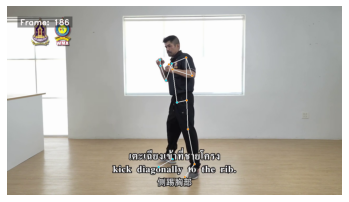

In [310]:
plt.axis(False)
plt.imshow(all_frame_test[186][:,:,::-1])

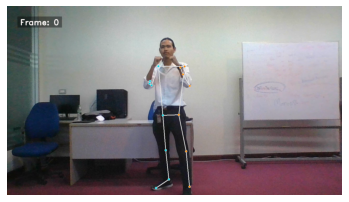

In [324]:
plt.axis(False)
plt.imshow(all_frame_test2[0][:,:,::-1])

In [437]:
def dtw_keyframe(name_vid1: str, name_vid2: str, extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, keyframes_list: list, sim_diff_function, path_finder, weight,
                 norm_value=180, windows=50, thresh=False, MAW_method='aj', expo=False):

    thresh_name=''
    expo_name=''
    keyframe_name=''

    if 2 in set(weight):
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if isinstance(weight, float):
        weight_name = '-MAW'
    else:
        window = ''

    if thresh:
        thresh_name = '-thresh'

    if expo:
        expo_name = '-expo'

    if MAW_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframes_list != []:
        keyframe_name = '-keyframe'

    if keyframes_list == []:
        return dtw(name_vid1,
                   name_vid2,
                   extracted_ladk_vid1=extracted_ladk_vid1,
                   extracted_ladk_vid2=extracted_ladk_vid2,
                   sim_diff_function=sim_diff_function,
                   path_finder=path_finder,
                   weight=weight,
                   norm_value=norm_value,
                   windows=windows,
                   thresh=thresh,
                   MAW_method=MAW_method,
                   expo=expo)

    dist_lndmk_mat, dist_mat = dm(extracted_ladk_vid1=extracted_ladk_vid1,
                                  extracted_ladk_vid2=extracted_ladk_vid2,
                                  sim_diff_function=sim_diff_function,
                                  weight=weight,
                                  norm_value=norm_value,
                                  windows=windows,
                                  method=MAW_method,
                                  expo=expo)

    if 'difference' in sim_diff_function.__name__:
        dist_mat = 1-dist_mat

    keyframes_list, student_kf = match_kf(keyframes_list, dist_mat)

    all_vert_hor = 0
    all_row = np.array([], dtype=np.uint16).reshape(0, 1)
    all_col = np.array([], dtype=np.uint16).reshape(0, 1)
    # print(keyframes_list)
    # print(student_kf)

    for ks, ke, stks, stke in list(zip(keyframes_list, keyframes_list[1:], student_kf, student_kf[1:])):

        # print('ks:',ks, 'ke:',ke, 'stks:',stks, 'stke:',stke)
        # print('dist_mat shape:', dist_mat[ks:ke+1,stks:stke+1].shape)
        path, cost_mat, vert_hor = path_finder(
            dist_mat[ks:ke+1, stks:stke+1], sim_diff_function.__name__)

        row = (np.asarray(path)+ks)[:, 0].reshape(-1, 1)
        col = (np.asarray(path)+stks)[:, 1].reshape(-1, 1)

        all_row = np.vstack((all_row, row))
        all_col = np.vstack((all_col, col))

        all_vert_hor += vert_hor

    all_path = np.unique(np.hstack((all_row, all_col)), axis=0)

    dist_mat_path = dist_mat[all_path[:, 0], all_path[:, 1]]
    dist_mat_unique = dist_mat[unique_path(all_path)[:, 0], unique_path(all_path)[:, 1]]
    unique_frames_count = dist_mat_unique.shape[0]

    cost = np.mean(dist_mat_path)
    std_all = np.std(dist_mat_path, dtype=np.float32)
    std_unique = np.std(dist_mat_unique, dtype=np.float32)
    mean = np.mean(dist_mat_path, dtype=np.float32)

    if thresh:
        thresh = np.mean(dist_mat_path)-0.03
        cost = np.sum(dist_mat_path[dist_mat_path > thresh])/all_path.shape[0]

    # df1 = pd.DataFrame({'Unique_frames':list(unique_path(all_path)), 'Sim_score':list(dist_mat_unique)})
    # df1.to_csv("{}{}dtw_{}_{}_{}{}dtw_{}_{}_{}_{}{}{}{}{}{}{}.csv".format(desktop+slash+'dtw', slash, name_vid1, name_vid2, sim_diff_function.__name__,
    #                                                           slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
    #                                                          weight_name,window,maw_met_name,expo_name,thresh_name,keyframe_name))

    # df2 = pd.DataFrame({'Teacher_kf': keyframes_list, 'Student_kf': student_kf,
    #                     'Sim_Score': dist_mat[np.array(keyframes_list), np.array(student_kf)]})
    # df2.to_csv("{}{}dtw_{}_{}_{}{}dtw_{}_kf_{}_kf_{}_{}{}{}{}{}{}{}.csv".format(desktop+slash+'dtw', slash, name_vid1, name_vid2, sim_diff_function.__name__,
    #                                                                 slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
    #                                                                            weight_name,window,maw_met_name,expo_name,thresh_name,keyframe_name))

    return keyframes_list, student_kf, all_path, dist_mat, dist_lndmk_mat, cost_mat, all_vert_hor, cost, [std_all, std_unique, mean, unique_frames_count]

In [438]:
keyframes_list, student_kf, all_path_kf, dist_mat_kf, dist_lndmk_mat_kf, cost_mat_kf, all_vert_hor_kf, cost_kf, stats_kf = dtw_keyframe('เตะเฉียงหน้า', 'เตะเฉียงหน้า_2', limb_vid1, limb_vid2, [186,214], cosine_similarity, dp, weight_cosine)

[0, 186, 214, 273]
[0, 48, 163, 239]
ks: 0 ke: 186 stks: 0 stke: 48
ks: 186 ke: 214 stks: 48 stke: 163
ks: 214 ke: 273 stks: 163 stke: 239


In [439]:
cost_kf

0.9462301847039715

In [64]:
def save_kf_img(name_vid1, name_vid2, all_frame_vid1, all_frame_vid2, kf, stu_kf, des_path):

    !mkdir "{des_path}{slash}kf_img"

    for i,j in zip(kf, stu_kf):

        match_kf_img = cv2.hconcat([all_frame_vid1[i][:,:,::-1], all_frame_vid2[j][:,:,::-1]])
        plt.axis(False)
        plt.imshow(match_kf_img)
        plt.savefig('{}{}kf_img{}{}_{}_{}_{}'.format(des_path, slash, slash, name_vid1, name_vid2, i, j),bbox_inches='tight')

# Display

## Create legend

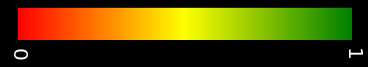

In [65]:
import matplotlib.colors


def color_legend():
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["red", "yellow", "green"])
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))

    fig, ax = plt.subplots(1, figsize=(6, 2), facecolor='black')
    plt.tick_params(axis='x', labelcolor=[1, 1, 1])
    plt.tick_params(axis='x', labelsize=20)
    ax.get_yaxis().set_visible(False)
    ax.imshow([colors], extent=[0, 10, 0, 1])
    ax.set(xticks=([0, 10]))
    ax.set(xticklabels=([0, 1]))
    ax.tick_params(axis='x', labelrotation=-90)
    plt.savefig(resource + '{}color_legend.png'.format(slash),
                facecolor=fig.get_facecolor())
    return fig


cl = color_legend()

In [66]:
def add_cl(image, y, x, width_ratio, height_ratio, dist, sim_diff_function):

    cl = cv2.imread(resource + '{}color_legend.png'.format(slash))

    dim = (int(image.shape[0]*height_ratio), int(image.shape[1]*width_ratio))
    cl = cv2.resize(cl, dim)
    cl_img = cv2.rotate(cl, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cl_height, cl_width, _ = cl_img.shape

    if 'similarity' in sim_diff_function.__name__.lower():
        dist = 1 - dist

    dist_y = dist*cl_height

    start_point = (int(0.7*cl_width), int(0.1*cl_height))
    end_point = (int(cl_width-(0.7*cl_width)), int(int(0.1*cl_height)+dist_y))
    cv2.rectangle(cl_img, start_point, end_point, (0, 0, 0), -1)

    gray_cl = cv2.cvtColor(cl_img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_cl, 0, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    roi = image[y:y+cl_height, x:x+cl_width]
    img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    result = cv2.add(img_bg, cl_img)
    image[y:y+cl_height, x:x+cl_width] = result

    alpha = 0.5
    beta = (1.0 - alpha)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    dst = cv2.addWeighted(
        image[y:y+cl_height, x:x+cl_width], alpha, mask, beta, 0.0)

    image[y:y+cl_height, x:x+cl_width] = dst

    ps.putBText(image, "Similarity score",
                text_offset_x=10, text_offset_y=y-20, vspace=5, hspace=5,
                font_scale=0.5, background_RGB=(0, 0, 0), text_RGB=(255, 250, 250))

## Progress bar

In [67]:
def progressBar(image: np.array, dist: float, cost: float, sim_diff_function):
    """
    วาดหลอดแสดงค่าคะแนน แสดงเป็นค่าความเหมือน

    input:
        image : frame ภาพที่จะวาด
        dist : ค่าคะแนนความต่าง/ความเหมือนต่อเฟรม
        cost : ยอดสะสมค่าคะแนนความต่าง/ความเหมือน
        sim_diff_function : ฟังก์ชันที่ใช้ในการคำนวณความต่าง/ความเหมือน

    output:
        หลอดแนวตั้ง: แสดงค่าความเหมือนของวิดิโอทั้ง 2 ในคู่เฟรมนั้นๆ
        หลอดแนวนอน: แสดงค่าความเหมือนรวมกันตั้งแต่ต้นยันจบของ 2 วิดิโอ
    """
    height, width, _ = image.shape

    if 'difference' in sim_diff_function.__name__.lower():
        dist = 1 - dist
        cost = 1 - cost

    cv2.line(image, (0, height), (width, height), (255, 255, 255), 40)
    cv2.line(image, (0, height), (int(cost*width), height), (50, 205, 50), 40)
    cv2.putText(image, 'Total Similarity Score: ', (0, height), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(image, '{:.2f}'.format(cost*100), (int(cost*width)-35, height), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 0), 2, cv2.LINE_AA)

## Error point

In [68]:
def form_vec(coor_arr: np.array):
    """
    เอาเฉพาะ x กับ y ในตำแหน่งข้อต่อ

    input:
        coor_arr: ตำแหน่งข้อต่อ 3 มิติ (x,y,z)

    output:
        ตำแหน่งข้อต่อ 2 มิติ
    """
    return (int(coor_arr[0]), int(coor_arr[1]))

In [69]:
def denormalize_landmark(cam_landmark: np.array, mapped_landmark: list, width: int, height: int):
    """
    denormalize landmark

    input:
        cam_landmark : ตำแหน่งข้อต่อแบบ camera coordinate
        mapped_landmark : ตำแหน่ง landmark ที่ k ใน cam_landmark
        width : ความกว้างของรูป (x)
        height : ความสูงของรูป (y)

    output:
        denorm_landmark : denormalized landmark
    """

    denorm_landmark = []
    for i in mapped_landmark:
        denorm_landmark.append(
            [cam_landmark[i][0]*width, cam_landmark[i][1]*height, cam_landmark[i][2]*width])
    denorm_landmark.append(
        [cam_landmark[19][0]*width, cam_landmark[19][1]*height, cam_landmark[19][2]*width])
    denorm_landmark.append(
        [cam_landmark[20][0]*width, cam_landmark[20][1]*height, cam_landmark[20][2]*width])
    denorm_landmark.append(
        [cam_landmark[31][0]*width, cam_landmark[31][1]*height, cam_landmark[31][2]*width])
    denorm_landmark.append(
        [cam_landmark[32][0]*width, cam_landmark[32][1]*height, cam_landmark[32][2]*width])

    return denorm_landmark

In [70]:
def map_landmark(sim_diff_function, k: int):
    """
    ฟังก์ชัน map ตำแหน่งของข้อพับทั้ง 12 หรือท่อนแขนท่อนขาทั้ง 16 เป็นตำแหน่งใน cam_landmark

    input:
        sim_diff_function : ฟังก์ชันที่ใช้ในการคำนวณค่าคะแนน
        k : ข้อพับ/ท่อนแขนท่อนขาที่เท่าไหร่

    output:
        dict_map[k] : ตำแหน่งของข้อพับ/ท่อนแขนท่อนขาที่ k ใน cam_landmark
    """

    if "angle" in sim_diff_function.__name__.lower():
        dict_map = {0: [16], 1: [14], 2: [12], 3: [24], 4: [26], 5: [
            28], 6: [15], 7: [13], 8: [11], 9: [23], 10: [25], 11: [27]}
    elif "cosine" in sim_diff_function.__name__.lower():
        dict_map = {0: [28, 32], 1: [26, 28], 2: [24, 26], 3: [12, 24], 4: [16, 20], 5: [14, 16], 6: [12, 14], 7: [27, 31], 8: [25, 27], 9: [23, 25],
                    10: [11, 23], 11: [15, 19], 12: [13, 15], 13: [11, 13], 14: [11, 12], 15: [23, 24]}
    return dict_map[k]

In [71]:
def color_error(cam_landmark: np.array, width: int, height: int, image: np.array, dist_lndmk_mat: np.array, k: int,
                weight: np.array, sim_diff_function):
    """
    ฟังก์ชันแสดงจุดที่ผิดพลาด

    input:
        cam_landmark : ตำแหน่งข้อต่อแบบ camera coordinate
        width : ความกว้างของรูป (x)
        height : ความสูงของรูป (y)
        image : รูปภาพ frame ที่ต้องการ
        dist_lndmk_mat : ค่าคะนนความต่าง/ความเหมือน ของแต่ละข้อต่อ ของทุกคู่เฟรม (แยกข้อต่อ/แยกท่อนแขนท่อนขา)
        k : ข้อต่อ/ท่อนแขนท่อนขา ที่เท่าไหร่ใน dist_lndmk_mat
        weight : ค่าถ่วงน้ำหนักที่ได้จาก csv config
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน

    output:
        new_image : ภาพที่แสดงจุดผิดพลาดไป 1 ข้อต่อ/ท่อนแขนท่อนขา
    """

    annotated_img = image.copy()
    denorm_landmark = denormalize_landmark(
        cam_landmark, map_landmark(sim_diff_function, k), width, height)

    for i in range(len(denorm_landmark)):
        cv2.circle(image, (int(denorm_landmark[i][0]), int(
            denorm_landmark[i][1])), 4, (255, 255, 255), -1)

    # ori_similarity = (dist_lndmk_mat[k]/weight[k])
    ori_similarity = dist_lndmk_mat[k]

    if "angle" in sim_diff_function.__name__.lower():
        bright = ori_similarity*255
        size = int(max(5, min(20, 1/(ori_similarity))))

        cv2.circle(annotated_img, (int(denorm_landmark[0][0]), int(
            denorm_landmark[0][1])), size, (0, bright, 255), -1)

    elif "cosine" in sim_diff_function.__name__.lower():
        bright = ori_similarity*255
        size = int(max(3, min(20, 1/(ori_similarity))))

        cv2.line(annotated_img, form_vec(denorm_landmark[0]), form_vec(
            denorm_landmark[1]), (0, bright, 255), size)

    opacity = 0.4
    new_image = cv2.addWeighted(annotated_img, opacity, image, 1 - opacity, 0)

    return new_image

## Graph

In [73]:
import wget
import matplotlib.font_manager as mpl

path = './thsarabunnew-webfont.ttf'

check_file = os.path.isfile(path)

if not check_file:

    URL = "https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf"
    wget.download(URL, "thsarabunnew-webfont.ttf")

mpl.fontManager.addfont("thsarabunnew-webfont.ttf")

In [74]:
def plot_dtw(path: list, cost_mat: np.array, name_vid1: str, name_vid2: str, sim_diff_function, destination_path: str):
    """
    plot กราฟเส้นทางที่ดีที่สุด (path) ของ DTW

    input:
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        cost_mat : cost matrix ผลรวมของคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรมในเส้นทาง ได้จากฟังก์ชัน dtw
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference

    output:
        path.png : กราฟแสดงเส้นทางของ DTW
    """

    print("{}-{} ({})".format(name_vid1, name_vid2, sim_diff_function.__name__))
    fig = plt.figure()
    plt.title("Path {}_{}_{}".format(
        name_vid1, name_vid2, sim_diff_function.__name__))
    plt.axis([-10, cost_mat.shape[1], -10, cost_mat.shape[0]])
    plt.grid(False)
    ax = plt.gca()
    ax.set_ylim(cost_mat.shape[0], -10)
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xlabel(name_vid2)
    ax.set_ylabel(name_vid1)

    x_path, y_path = zip(*path)
    ax.plot(y_path, x_path)
    plt.close()
    fig.savefig("{}{}dtw_{}_{}_{}{}path.png".format(destination_path,
                slash, name_vid1, name_vid2, sim_diff_function.__name__, slash))

In [75]:
def graph_dist_path(dist_mat: np.array, path: list, name_vid1: str, name_vid2: str, sim_diff_function, destination_path: str):
    """
    plot line chart แสดงค่าคะแนนความต่าง/ความเหมือน ต่อ คู่เฟรมใน path

    input:
        dist_mat : distance matrix เมทริกซ์แสดงคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรม (รวมทุกข้อต่อ/ท่อนแขนท่อนขา)
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference

    output:
        graph.png : กราฟแกน x เป็นคู่เฟรมที่อยู่ใน path แกน y เป็นค่าคะแนนความต่าง/ความเหมือน
    """

    dist_df = pd.DataFrame({'path': [str(i) for i in path], 'norm_difference': [
                           dist_mat[i, j] for i, j in path]})
    dist_df['std'] = dist_df['norm_difference'].std()
    dist_df['lower_bound'] = dist_df.apply(
        lambda x: x['norm_difference']-x['std'], axis=1)
    dist_df['upper_bound'] = dist_df.apply(
        lambda x: x['norm_difference']+x['std'], axis=1)
    fig = plt.figure(figsize=(100, 8))
    plt.plot(dist_df['path'], dist_df['norm_difference'])
    plt.fill_between(dist_df['path'], dist_df['lower_bound'],
                     dist_df['upper_bound'], color='b', alpha=.15)
    plt.title("difference")
    plt.xlabel('Path')
    plt.ylabel('difference')
    plt.xticks(rotation=90)
    plt.close()
    fig.savefig("{}{}{}_dtw_{}_{}{}graph.png".format(destination_path,
                slash, name_vid1, name_vid2, sim_diff_function.__name__, slash))

## Export Vdo

In [76]:
def hconcat_resize(img_list: list):
    """
    ต่อภาพที่ขนาดไม่เท่ากัน

    input:
        img_list : list ของรูปภาพที่ต้องการต่อ ex. [img1,img2]

    output:
        im_list_resize : รูปภาพที่ต่อกันแล้ว
    """
    # take minimum hights
    h_min = min(img.shape[0]
                for img in img_list)

    # image resizing
    im_list_resize = [cv2.resize(img,
                                 (int(img.shape[1] * h_min / img.shape[0]),
                                  h_min), interpolation=cv2.INTER_CUBIC)
                      for img in img_list]

    # return final image
    return cv2.hconcat(im_list_resize)

In [77]:
def display_img(name_vid1: str, name_vid2: str, path: list, dist_mat: np.array, dist_lndmk_mat: np.array,
                weight: np.array, sim_diff_function, path_finder, all_frame1: list, all_frame2: list, cam_land_vid1: np.array,
                cam_land_vid2: np.array, destination_path: str):
    """
    แสดงผลและเซฟรูป/วิดิโอ

    input:
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        dist_mat : distance matrix เมทริกซ์แสดงคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรม (รวมทุกข้อต่อ/ท่อนแขนท่อนขา)
        dist_lndmk_mat : ค่าคะนนความต่าง/ความเหมือน ของแต่ละข้อต่อ ของทุกคู่เฟรม (แยกข้อต่อ/แยกท่อนแขนท่อนขา) (ใช้แสดงจุดผิดพลาด)
        weight : ค่าถ่วงน้ำหนักที่ได้จาก csv config
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference
        all_frame1 : รูปภาพทุกเฟรมของวิดิโอที่ 1 ที่วาดโครงกระดูกแล้ว
        all_frame2 : รูปภาพทุกเฟรมของวิดิโอที่ 2 ที่วาดโครงกระดูกแล้ว
        cam_land_vid1 : ตำแหน่งข้อต่อแบบ camera coordinate ของวิดิโอที่ 1
        cam_land_vid2 : ตำแหน่งข้อต่อแบบ camera coordinate ของวิดิโอที่ 2

    output:
        folder : dtw_ชื่อวิดิโอที่1_ชื่อวิดิโอที่2_ชื่อฟังก์ชัน sim_diff_function
    """
    if len(set(weight)) > 1:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'
    height, width, _ = hconcat_resize([all_frame1[0], all_frame2[0]]).shape
    out = cv2.VideoWriter("{}{}dtw_{}_{}_{}{}dtw_{}_{}_{}_{}{}-keyframe.avi".format(destination_path, slash, name_vid1, name_vid2, sim_diff_function.__name__,
                                                                         slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
                                                                          weight_name),
                          cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 30, (width, height))

    cl = cv2.imread(resource + '{}color_legend.png'.format(slash))
    cl_img = cv2.rotate(cl, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cl_height, cl_width, _ = cl_img.shape
    cost = 0
    for i, j in path:

        img1 = all_frame1[i].copy()
        img2 = all_frame2[j].copy()
        height1, width1, _ = img1.shape
        height2, width2, _ = img2.shape
        height_ratio = cl_height/max(height1, height2)
        width_ratio = cl_width/max(width1, width2)

        add_cl(image=img2,
               y=int((height2/2)-(height2*height_ratio)/2),
               x=0,
               width_ratio=width_ratio,
               height_ratio=height_ratio,
               dist=dist_mat[i, j],
               sim_diff_function=sim_diff_function)

        cost += dist_mat[i, j]/len(path)

        progressBar(image=img2,
                    dist=dist_mat[i, j],
                    cost=cost,
                    sim_diff_function=sim_diff_function)

        for k in range(dist_lndmk_mat[i, j].shape[0]):

            # color_error ใช้ได้กับ similarity อย่างเดียว
            if "similarity" in sim_diff_function.__name__.lower():
                img1 = color_error(
                    cam_land_vid1[i], width1, height1, img1, dist_lndmk_mat[i, j], k, weight, sim_diff_function)
                img2 = color_error(
                    cam_land_vid2[j], width2, height2, img2, dist_lndmk_mat[i, j], k, weight, sim_diff_function)
            elif "difference" in sim_diff_function.__name__.lower():
                img1 = color_error(
                    cam_land_vid1[i], width1, height1, img1, 1-dist_lndmk_mat[i, j], k, weight, sim_diff_function)
                img2 = color_error(
                    cam_land_vid2[j], width2, height2, img2, 1-dist_lndmk_mat[i, j], k, weight, sim_diff_function)

        merge_img = hconcat_resize([img1, img2])

        out.write(merge_img)

    out.release()

# Warp up

In [78]:
diff_angle_dict = {"เข่าตรงหลัง_เฉียง": [157, 175],
                   "เข่าตรงหลัง_ตรง": [178, 222],
                   "เข่าพร้อมศอกหลัง_เฉียง": [104, 130],
                   "เข่าพร้อมศอกหลัง_ตรง": [125, 153],
                   "เตะเฉียงหน้า_เฉียง": [102, 129],
                   "เตะเฉียงหน้า_ตรง": [92, 124],
                   "เตะเฉียงหลัง_เฉียง": [107, 138],
                   "เตะเฉียงหลัง_ตรง": [118, 145],
                   "ศอกเฉียงตีขึ้นหน้า_เฉียง": [95, 131],
                   "ศอกเฉียงตีขึ้นหน้า_ตรง": [95, 124, 165],
                   "ศอกเฉียงหลัง_เฉียง": [93, 143],
                   "ศอกเฉียงหลัง_ตรง": [87, 136],
                   "หมัดกระแทกหน้า_เฉียง": [121, 147],
                   "หมัดกระแทกหน้า_ตรง": [119, 140]}

In [79]:
friends_video_dict = {"เข่าพร้อมศอกหลัง":[135, 169],
                      "เข่าพร้อมศอกหลัง_1":[103, 132],
                      "เข่าพร้อมศอกหลัง_2":[136,154],
                      "เข่าพร้อมศอกหลัง_3":[102, 139],
                      "เข่าพร้อมศอกหลัง_4":[128, 150],
                      "เข่าพร้อมศอกหลัง_5":[59, 78],
                      "เตะเฉียงหน้า":[186, 214],
                      "เตะเฉียงหน้า_1":[107, 130],
                      "เตะเฉียงหน้า_2":[148, 166],
                      "เตะเฉียงหน้า_3":[172, 189],
                      "เตะเฉียงหน้า_4":[82, 96],
                      "เตะเฉียงหน้า_5":[140, 166],
                      "ศอกเฉียงตีขึ้นหน้า":[124, 163],
                      "ศอกเฉียงตีขึ้นหน้า_1":[110, 155],
                      "ศอกเฉียงตีขึ้นหน้า_2":[119, 150],
                      "ศอกเฉียงตีขึ้นหน้า_3":[128, 151],
                      "ศอกเฉียงตีขึ้นหน้า_4":[85, 108],
                      "ศอกเฉียงตีขึ้นหน้า_5":[59, 69],
                      "เข่าตรงหลัง":[114, 144],
                      "เข่าตรงหลัง_1":[100, 119],
                      "เข่าตรงหลัง_2":[75, 101],
                      "เข่าตรงหลัง_3":[67, 102],
                      "เข่าตรงหลัง_4":[115, 143],
                      "เข่าตรงหลัง_5":[111, 135],
                      "หมัดกระแทกหน้า":[160, 194],
                      "หมัดกระแทกหน้า_1":[99, 130],
                      "หมัดกระแทกหน้า_2":[147, 178],
                      "หมัดกระแทกหน้า_3":[121, 140],
                      "หมัดกระแทกหน้า_4":[89, 107],
                      "หมัดกระแทกหน้า_5":[139,208]
                      }

In [80]:
!mkdir "{desktop}{slash}dtw"

A subdirectory or file C:\Users\Gear\Desktop\dtw already exists.


In [81]:
# w/ keyframe
def comparevid_kf(path_landmark1: str, path_landmark2: str, keyframes_list: list, destination_path: str, sim_diff_function, extract_function, path_finder,
                 norm_value = 180, weight = False, thresh = False, expo = False, MAW_method = 'aj', windows = 30, video = False, kf_img = False, showtext=True):

    name_vid1 = path_landmark1.split(slash)[-1]
    name_vid2 = path_landmark2.split(slash)[-1]
    name_func = sim_diff_function.__name__.split('_')[0]

    thresh_name=''
    expo_name=''
    keyframe_name=''

    if weight:
        weight_name = 'Weight'
    else:
        weight_name = 'Unweight'

    if weight == 'auto':
        weight_name = 'MAW'
    else:
        window = ''

    if thresh:
        thresh_name = '-thresh'

    if expo:
        expo_name = '-expo'

    if MAW_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframes_list != []:
        keyframe_name = '-keyframe'

    if weight == 'auto':
        weight = 'auto'
    elif weight:
        weight = import_weight(resource + '{}weight_config_{}_list.csv'.format(slash, name_func), name_vid1.split('_')[0])
    else:
        weight = import_weight(resource + '{}weight_config_{}_list.csv'.format(slash, name_func), "default")

    cam_land_vid1, world_land_vid1, all_frame1, = import_file(path_landmark1)
    cam_land_vid2, world_land_vid2, all_frame2 = import_file(path_landmark2)

    extracted_ladk_vid1 = extract_function(world_land_vid1)
    extracted_ladk_vid2 = extract_function(world_land_vid2)

    kf_list, stkf_list, path, dist_mat, dist_lndmk_mat, cost_mat, vert_hor, cost, stats = dtw_keyframe(name_vid1, name_vid2,
                                                                                   extracted_ladk_vid1, extracted_ladk_vid2,
                                                                                   keyframes_list, sim_diff_function,
                                                                                   path_finder, weight,
                                                                                   norm_value, windows, thresh,
                                                                                   MAW_method, expo)

    if (kf_list != None) and (kf_img):
        dtw_path=desktop+slash+'dtw'
        # !rm -rf "{dtw_path}/dtw_{name_vid1}_{name_vid2}_{sim_diff_function.__name__}"
        !mkdir "{dtw_path}{slash}dtw_{name_vid1}_{name_vid2}_{sim_diff_function.__name__}"
        !mkdir "{dtw_path}{slash}dtw_{name_vid1}_{name_vid2}_{sim_diff_function.__name__}{slash}{weight_name}{window}{maw_met_name}{expo_name}{thresh_name}{keyframe_name}"

        save_kf_img(name_vid1, name_vid2, all_frame1, all_frame2,
                    kf_list, stkf_list, '{}{}dtw_{}_{}_{}{}{}{}{}{}{}{}'.format(dtw_path, slash, name_vid1, name_vid2, sim_diff_function.__name__, slash,
                                                                                weight_name, window, maw_met_name, expo_name, thresh_name, keyframe_name))

    Non_sync_one_to_many_pair  = vert_hor - (np.abs(len(all_frame1) - len(all_frame2)))
    Non_sync_one_to_many_pair_percent = ((Non_sync_one_to_many_pair /min(len(all_frame1), len(all_frame2))) *100)/2

    if showtext:
        print('จำนวนคู่เฟรมใน path : ' + str(len(path)))
        print('จำนวนเฟรมของ vdo 1 : ' + str(len(all_frame1)))
        print('จำนวนเฟรมของ vdo 2 : ' + str(len(all_frame2)))
        print('จำนวนเฟรม vdo1 - vdo2 : ' + str(np.abs(len(all_frame1) - len(all_frame2))))
        print('จำนวนแนวนอนแนวตั้ง:' + str(vert_hor))
        print('Non_sync_one_to_many_pair :' + str(Non_sync_one_to_many_pair ))
        print('Non_sync_one_to_many_pair_percent :' + str(Non_sync_one_to_many_pair_percent ))

    if video:

        display_img(name_vid1, name_vid2, path, dist_mat, dist_lndmk_mat, weight,
                    sim_diff_function, path_finder, all_frame1, all_frame2, cam_land_vid1, cam_land_vid2,
                    destination_path)

        # doesn't have cost_mat
        # plot_dtw(path, cost_mat, name_vid1, name_vid2, sim_diff_function, destination_path)

    return cost, Non_sync_one_to_many_pair_percent, stats, kf_list, stkf_list, dist_mat

In [82]:
cam1,world1,frame1 = import_file(friends_video + '{}landmarks{}ศอกเฉียงตีขึ้นหน้า{}ศอกเฉียงตีขึ้นหน้า'.format(slash, slash, slash))
cam2,world2,frame2 = import_file(friends_video + '{}landmarks{}ศอกเฉียงตีขึ้นหน้า{}ศอกเฉียงตีขึ้นหน้า_1'.format(slash, slash, slash))

In [ ]:
# cost_kf, non_sync_kf, stats_kf = comparevid_kf(diff_angle + '{}landmarks{}เข่าตรงหลัง{}เข่าตรงหลัง_ตรง'.format(slash, slash, slash),
#                                             diff_angle + '{}landmarks{}เข่าตรงหลัง{}เข่าตรงหลัง_เฉียง'.format(slash, slash, slash),
#                                             diff_angle_dict['เข่าตรงหลัง_ตรง'],
#                                             desktop+slash+'dtw',
#                                             angle_similarity, find_angle, dp,
#                                             weight = False,
#                                             norm_value=45,
#                                             windows=30, thresh=False, expo=False, video=False)

In [ ]:
# cost_kf, non_sync_kf, stats_kf = comparevid_kf(friends_video + '{}landmarks{}หมัดกระแทกหน้า{}หมัดกระแทกหน้า_4'.format(slash, slash, slash),
#                                             friends_video + '{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า'.format(slash, slash, slash),
#                                             friends_video_dict['หมัดกระแทกหน้า_4'],
#                                             desktop+slash+'dtw',
#                                             angle_similarity, find_angle, dp,
#                                             weight = False,
#                                             norm_value=45,
#                                             windows=60, thresh=False, expo=False, video=False)

In [ ]:
# cost_kf, non_sync_kf, stats_kf = comparevid_kf(friends_video + '{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า'.format(slash, slash, slash),
#                                             friends_video + '{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า_2'.format(slash, slash, slash),[],
#                                             desktop+slash+'dtw',
#                                             cosine_similarity, find_limb, dp,
#                                             weight = False,
#                                             norm_value=45,
#                                             windows=60, thresh=False, expo=False, video=True)

In [ ]:
# cost_kf, non_sync_kf, stats_kf = comparevid_kf(friends_video + '{}landmarks{}หมัดกระแทกหน้า{}หมัดกระแทกหน้า'.format(slash, slash, slash),
#                                             friends_video + '{}landmarks{}เข่าพร้อมศอกหลัง{}เข่าพร้อมศอกหลัง'.format(slash, slash, slash),[],
#                                             desktop+slash+'dtw',
#                                             cosine_difference, find_limb, dp,
#                                             weight = False,
#                                             norm_value=45,
#                                             windows=60, thresh=False, expo=True, video=True)

# Summary report

In [83]:
def warp_sum_cosine_kf(path_vid1: str, path_vid2: str, keyframe_list: list, weight, norm_value: int,
                       windows=30, thresh=False, MAW_method='aj', expo=False, video=False, kf_img=False):

    # bottom-right to top-left
    cost_sim_dp, non_sync_diff_sim_dp, stats_sim_dp, kf, stkf, dist_mat = comparevid_kf(path_landmark1=path_vid1,
                                                                                        path_landmark2=path_vid2,
                                                                                        keyframes_list=keyframe_list,
                                                                                        destination_path=desktop+slash+'dtw',
                                                                                        sim_diff_function=cosine_similarity,
                                                                                        extract_function=find_limb,
                                                                                        path_finder=dp,
                                                                                        weight=weight,
                                                                                        norm_value=norm_value,
                                                                                        windows=windows,
                                                                                        showtext=False,
                                                                                        thresh=thresh,
                                                                                        MAW_method=MAW_method,
                                                                                        expo=expo,
                                                                                        video=video,
                                                                                        kf_img=kf_img)

    cost_list = [cost_sim_dp]
    frames_list = [stats_sim_dp[3]]
    mean_list = [stats_sim_dp[2]]
    std_uni_list = [stats_sim_dp[1]]
    std_all_list = [stats_sim_dp[0]]
    non_sync_list = [non_sync_diff_sim_dp]
    method_list = ['cosine similarity (br-tl)']
    vid_name_list = ['{}_{}'.format(path_vid1.split(
        slash)[-1], path_vid2.split(slash)[-1])]

    return cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf, stkf, dist_mat

In [84]:
warp_sum_cosine_kf(friends_video + '{}landmarks{}หมัดกระแทกหน้า{}หมัดกระแทกหน้า_4'.format(slash, slash, slash),
                friends_video + '{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า'.format(slash, slash, slash),
                friends_video_dict['หมัดกระแทกหน้า_4'],
                weight = False,
                norm_value=45,
                windows=60, thresh=False, expo=False, video=False,
                kf_img=False)

([0.3375431457743669],
 [0.33754316],
 [0.7029176],
 [0.07193465],
 [4],
 [2.18978102189781],
 ['cosine similarity (br-tl)'],
 ['หมัดกระแทกหน้า_4_เตะเฉียงหน้า'],
 [89, 107],
 [147, 271],
 array([[-0.25109051, -0.16302841, -0.17739729, ..., -0.14417077,
         -0.13022386, -0.12917363],
        [-0.32213427, -0.23716039, -0.25068881, ..., -0.20869654,
         -0.19632855, -0.19562258],
        [-0.3046915 , -0.21321053, -0.22604587, ..., -0.1787982 ,
         -0.16572222, -0.16528289],
        ...,
        [ 0.62170361,  0.73984661,  0.74272835, ...,  0.7610599 ,
          0.77349541,  0.77839952],
        [ 0.61726333,  0.73427028,  0.73728669, ...,  0.75552701,
          0.76860425,  0.77336549],
        [ 0.63253773,  0.74793408,  0.75077402, ...,  0.76897071,
          0.78153769,  0.78636964]]))

In [85]:
warp_sum_cosine_kf(diff_angle + '{}landmarks{}เข่าตรงหลัง{}เข่าตรงหลัง_ตรง'.format(slash, slash, slash),
                diff_angle + '{}landmarks{}เข่าตรงหลัง{}เข่าตรงหลัง_เฉียง'.format(slash, slash, slash),
                diff_angle_dict['เข่าตรงหลัง_ตรง'],
                weight = False,
                norm_value=45,
                windows=30, thresh=False, expo=False, video=False,
                kf_img=False)

([0.7957518280200635],
 [0.79575187],
 [0.05747273],
 [0.049666487],
 [14],
 [16.367713004484305],
 ['cosine similarity (br-tl)'],
 ['เข่าตรงหลัง_ตรง_เข่าตรงหลัง_เฉียง'],
 [178, 222],
 [180, 212],
 array([[-0.43305007,  0.61392401,  0.75290611, ...,  0.81995291,
          0.82153139,  0.82364631],
        [-0.33599059,  0.53735504,  0.61600352, ...,  0.69831752,
          0.70375552,  0.70886926],
        [-0.30973273,  0.54322815,  0.62229854, ...,  0.67900289,
          0.68844336,  0.69629878],
        ...,
        [-0.37004876,  0.56882066,  0.67660084, ...,  0.77598515,
          0.78376811,  0.79076348],
        [-0.3753619 ,  0.56350484,  0.67547168, ...,  0.77707068,
          0.78489843,  0.79164339],
        [-0.38027635,  0.58528228,  0.70931071, ...,  0.8017163 ,
          0.80923139,  0.8156026 ]]))

In [86]:
def warp_sum_angle_kf(path_vid1: str, path_vid2: str, keyframe_list: list, weight, norm_value: int,
                      windows=30, thresh=False,  MAW_method='aj', expo=False, video=False, kf_img=False):

    # bottom-right to top-left
    cost_sim_dp, non_sync_diff_sim_dp, stats_sim_dp, kf, stkf, dist_mat = comparevid_kf(path_landmark1=path_vid1,
                                                                                        path_landmark2=path_vid2,
                                                                                        keyframes_list=keyframe_list,
                                                                                        destination_path=desktop+slash+'dtw',
                                                                                        sim_diff_function=angle_similarity,
                                                                                        extract_function=find_angle,
                                                                                        path_finder=dp,
                                                                                        weight=weight,
                                                                                        norm_value=norm_value,
                                                                                        windows=windows,
                                                                                        showtext=False,
                                                                                        thresh=thresh,
                                                                                        MAW_method=MAW_method,
                                                                                        expo=expo,
                                                                                        video=video,
                                                                                        kf_img=kf_img)

    cost_list = [cost_sim_dp]
    frames_list = [stats_sim_dp[3]]
    mean_list = [stats_sim_dp[2]]
    std_uni_list = [stats_sim_dp[1]]
    std_all_list = [stats_sim_dp[0]]
    non_sync_list = [non_sync_diff_sim_dp]
    method_list = ['angle similarity (br-tl)']
    vid_name_list = ['{}_{}'.format(path_vid1.split(
        slash)[-1], path_vid2.split(slash)[-1])]

    return cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf, stkf, dist_mat

In [87]:
warp_sum_angle_kf(friends_video + '{}landmarks{}หมัดกระแทกหน้า{}หมัดกระแทกหน้า_4'.format(slash, slash, slash),
                friends_video + '{}landmarks{}เตะเฉียงหน้า{}เตะเฉียงหน้า'.format(slash, slash, slash),
                friends_video_dict['หมัดกระแทกหน้า_4'],
                weight = False,
                norm_value=45,
                windows=60, thresh=False, expo=False, video=False,
                kf_img=False)

([0.7201945863017553],
 [0.7201945],
 [0.14937583],
 [0.064490214],
 [11],
 [-13.138686131386862],
 ['angle similarity (br-tl)'],
 ['หมัดกระแทกหน้า_4_เตะเฉียงหน้า'],
 [89, 107],
 [150, 232],
 array([[0.3998703 , 0.46621316, 0.49330069, ..., 0.47386719, 0.48481073,
         0.49606569],
        [0.3357099 , 0.41088314, 0.43431366, ..., 0.42422277, 0.43516631,
         0.44642127],
        [0.32982893, 0.40614937, 0.43145776, ..., 0.42346684, 0.43441038,
         0.44566534],
        ...,
        [0.66803884, 0.73765323, 0.77083294, ..., 0.76481486, 0.77699343,
         0.78875643],
        [0.66695725, 0.73611073, 0.77040084, ..., 0.76240542, 0.77458399,
         0.78634699],
        [0.66707262, 0.73851721, 0.77179206, ..., 0.76395999, 0.77613856,
         0.78790156]]))

In [88]:
warp_sum_angle_kf(diff_angle + '{}landmarks{}เข่าตรงหลัง{}เข่าตรงหลัง_ตรง'.format(slash, slash, slash),
                diff_angle + '{}landmarks{}เข่าตรงหลัง{}เข่าตรงหลัง_เฉียง'.format(slash, slash, slash),
                diff_angle_dict['เข่าตรงหลัง_ตรง'],

                weight = False,
                norm_value=45,
                windows=30, thresh=False, expo=False, video=False,
                kf_img=False)

([0.836250141800542],
 [0.83625025],
 [0.03657171],
 [0.027094288],
 [19],
 [18.609865470852018],
 ['angle similarity (br-tl)'],
 ['เข่าตรงหลัง_ตรง_เข่าตรงหลัง_เฉียง'],
 [178, 222],
 [170, 212],
 array([[0.27674059, 0.41002553, 0.63130022, ..., 0.77578253, 0.78074557,
         0.77791089],
        [0.24630443, 0.4551208 , 0.67908326, ..., 0.77424049, 0.77920353,
         0.77636885],
        [0.277611  , 0.46547263, 0.69677866, ..., 0.72830572, 0.73560175,
         0.73529629],
        ...,
        [0.31775928, 0.48060671, 0.74150384, ..., 0.82296156, 0.8302576 ,
         0.83092582],
        [0.3141736 , 0.47797209, 0.73750067, ..., 0.82490615, 0.83220218,
         0.83237171],
        [0.315086  , 0.47639147, 0.7462323 , ..., 0.82938014, 0.83706509,
         0.8365923 ]]))

In [103]:
def case1_kf(path: str, keyframe_dict: dict, weight, threshold: bool, exponential: bool,
             angle_cosine_func, auto_method='aj', window=30, video=True, kf_img=False):

    thresh_name = ''
    expo_name = ''
    keyframe_name = ''

    if weight:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if weight == 'auto':
        weight_name = '-MAW'
    else:
        window = ''

    if threshold:
        thresh_name = '-thresh'

    if exponential:
        expo_name = '-expo'

    if auto_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframe_dict != []:
        keyframe_name = '-keyframe'

    func_name = angle_cosine_func.__name__.split('_')[2]

    norm_val_list = [45] # เฉพาะ 45 องศา
    all_cost_list = []
    all_mean_list = []
    all_std_all_list = []
    all_std_uni_list = []
    all_frames_list = []
    all_non_sync_list = []
    all_method_list = []
    all_vid_name_list = []
    all_norm_list = []
    all_case_list = []
    all_kf_list = []
    all_stkf_list = []
    all_kf_score_list = []
    all_kf_mean_list = []

    # kf_file=glob(f'{desktop}{slash}dtw{slash}**{slash}dtw_*kf*')

    for norm in norm_val_list:
        for move in glob(path+'{}landmarks{}**'.format(slash, slash)):
            path_vid1 = glob('{}{}**'.format(move, slash))[0]
            path_vid2 = glob('{}{}**'.format(move, slash))[1]
            vid1_name = path_vid1.split(slash)[-1]
            vid2_name = path_vid2.split(slash)[-1]

            # check_file_name = f'{desktop}{slash}dtw{slash}dtw_{vid1_name}_{vid2_name}_{func_name}_similarity{slash}dtw_{vid1_name}_kf_{vid2_name}_kf_{func_name}_similarity_dp{weight_name}{window}{maw_met_name}{expo_name}{thresh_name}{keyframe_name}.csv'

            # print(check_file_name)

            # if check_file_name in kf_file:
            #     print('already has file')
            #     continue
            if keyframe_dict == []:
                kf = []
            else:
                kf = keyframe_dict[vid1_name]

            cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf, stkf, dist_mat = angle_cosine_func(path_vid1=path_vid1,
                                                                                                                                         path_vid2=path_vid2,
                                                                                                                                         keyframe_list=kf,
                                                                                                                                         weight=weight,
                                                                                                                                         norm_value=norm,
                                                                                                                                         thresh=threshold,
                                                                                                                                         windows=window,
                                                                                                                                         expo=exponential,
                                                                                                                                         MAW_method=auto_method,
                                                                                                                                         video=video,
                                                                                                                                         kf_img=kf_img)

            all_cost_list.extend(cost_list)
            all_mean_list.extend(mean_list)
            all_std_all_list.extend(std_all_list)
            all_std_uni_list.extend(std_uni_list)
            all_frames_list.extend(frames_list)
            all_non_sync_list.extend(non_sync_list)
            all_method_list.extend(method_list)
            all_vid_name_list.extend(vid_name_list)
            all_norm_list.extend([norm])
            all_case_list.extend(['case1'])
            all_kf_list.append(kf)
            all_stkf_list.append(stkf)
            all_kf_score_list.append(dist_mat[np.array(kf), np.array(stkf)])
            all_kf_mean_list.append(np.mean(dist_mat[np.array(kf), np.array(stkf)]))

    df_case1 = pd.DataFrame({'Video_name': all_vid_name_list,
                             'Similarity_score': all_cost_list,
                             'Mean': all_mean_list,
                             'Std_all.': all_std_all_list,
                             'Std_unique': all_std_uni_list,
                             'All_frames_list': all_frames_list,
                             'Non_sync_percent': all_non_sync_list,
                             'Method': all_method_list,
                             'Normalize_value': all_norm_list,
                             'Case': all_case_list,
                             'Teacher_keyframes': all_kf_list,
                             'Student_keyframes': all_stkf_list,
                             'Keyframe_scores': all_kf_score_list,
                            'Keyframe_mean_score': all_kf_mean_list})

    weight_name = weight_name.replace('-','')
    file_name = '{}{}{}{}{}{}_{}_case1'.format(weight_name, window, maw_met_name, expo_name,
                                                   thresh_name, keyframe_name, func_name)

    if glob(desktop + slash + file_name + '*') != 0:
        num = len(glob(desktop + slash + file_name + '*'))
        df_case1.to_csv(desktop + slash + file_name + '({})'.format(num) + '.csv')
    else:
        df_case1.to_csv(desktop + slash + file_name + '.csv')

In [104]:
def case2_kf(path1: str, path2: str, keyframe_dict: dict, weight, threshold: bool, exponential: bool,
               angle_cosine_func, auto_method='aj', window=30, video=True, kf_img=False):

    thresh_name = ''
    expo_name = ''
    keyframe_name = ''

    if weight:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if weight == 'auto':
        weight_name = '-MAW'
    else:
        window = ''

    if threshold:
        thresh_name = '-thresh'

    if exponential:
        expo_name = '-expo'

    if auto_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframe_dict != []:
        keyframe_name = '-keyframe'

    func_name = angle_cosine_func.__name__.split('_')[2]

    norm_val_list = [45] # เฉพาะ 45 องศา
    all_cost_list = []
    all_mean_list = []
    all_std_all_list = []
    all_std_uni_list = []
    all_frames_list = []
    all_non_sync_list = []
    all_method_list = []
    all_vid_name_list = []
    all_norm_list = []
    all_case_list = []
    all_kf_list = []
    all_stkf_list = []
    all_kf_score_list = []
    all_kf_mean_list = []

    # kf_file=glob(f'{desktop}{slash}dtw{slash}**{slash}dtw_*kf*')

    all_vid1 = glob(path1 + '{}landmarks{}**{}**[!0-9]'.format(slash, slash, slash))

    for norm in norm_val_list:
        for i in all_vid1:

            vid1_name = i.split(slash)[-1]

            all_vid2 = sorted(glob(path2 + '{}landmarks{}**{}*{}*[0-9]'.format(slash, slash, vid1_name, slash)))
            for j in all_vid2:
                vid2_name = j.split(slash)[-1]

                print(vid1_name)
                print(vid2_name)
                print('-----------')
                print(i)
                print(j)
                print('-----------')

                # check_file_name = f'{desktop}{slash}dtw{slash}dtw_{vid1_name}_{vid2_name}_{func_name}_similarity{slash}dtw_{vid1_name}_kf_{vid2_name}_kf_{func_name}_similarity_dp{weight_name}{window}{maw_met_name}{expo_name}{thresh_name}{keyframe_name}.csv'

                # print(check_file_name)

                # if check_file_name in kf_file:
                #     print('already has file')
                #     continue
                if keyframe_dict == []:
                    kf = []
                else:
                    kf = keyframe_dict[vid1_name]

                cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf, stkf, dist_mat = angle_cosine_func(path_vid1=i,
                                                                                                                                             path_vid2=j,
                                                                                                                                             keyframe_list=kf,
                                                                                                                                             weight=weight,
                                                                                                                                             norm_value=norm,
                                                                                                                                             windows=window,
                                                                                                                                             thresh=threshold,
                                                                                                                                             expo=exponential,
                                                                                                                                             MAW_method=auto_method,
                                                                                                                                             video=video,
                                                                                                                                             kf_img=kf_img)
                all_cost_list.extend(cost_list)
                all_mean_list.extend(mean_list)
                all_std_all_list.extend(std_all_list)
                all_std_uni_list.extend(std_uni_list)
                all_frames_list.extend(frames_list)
                all_non_sync_list.extend(non_sync_list)
                all_method_list.extend(method_list)
                all_vid_name_list.extend(vid_name_list)
                all_norm_list.extend([norm])
                all_case_list.extend(['case2'])
                all_kf_list.append(kf)
                all_stkf_list.append(stkf)
                all_kf_score_list.append(dist_mat[np.array(kf), np.array(stkf)])
                all_kf_mean_list.append(np.mean(dist_mat[np.array(kf), np.array(stkf)]))

    df_case2 = pd.DataFrame({'Video_name': all_vid_name_list,
                            'Similarity_score': all_cost_list,
                            'Mean': all_mean_list,
                            'Std_all.': all_std_all_list,
                            'Std_unique': all_std_uni_list,
                            'All_frames_list': all_frames_list,
                            'Non_sync_percent': all_non_sync_list,
                            'Method': all_method_list,
                            'Normalize_value': all_norm_list,
                            'Case': all_case_list,
                             'Teacher_keyframes': all_kf_list,
                             'Student_keyframes': all_stkf_list,
                             'Keyframe_scores': all_kf_score_list,
                             'Keyframe_mean_score': all_kf_mean_list})

    weight_name = weight_name.replace('-','')
    file_name = '{}{}{}{}{}{}_{}_case2'.format(weight_name, window, maw_met_name, expo_name,
                                                     thresh_name, keyframe_name, func_name)

    if glob(desktop + slash + file_name + '*') != 0:
        num = len(glob(desktop + slash + file_name + '*'))
        df_case2.to_csv(desktop + slash + file_name + '({})'.format(num) + '.csv')
    else:
        df_case2.to_csv(desktop + slash + file_name + '.csv')

In [105]:
def case3_kf(path1: str, path2: str, keyframe_dict: dict, weight, threshold: bool, exponential: bool,
               angle_cosine_func, auto_method='aj', window=30, video=True, kf_img=False):

    thresh_name = ''
    expo_name = ''
    keyframe_name = ''

    if weight:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if weight == 'auto':
        weight_name = '-MAW'
    else:
        window = ''

    if threshold:
        thresh_name = '-thresh'

    if exponential:
        expo_name = '-expo'

    if auto_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframe_dict != []:
        keyframe_name = '-keyframe'

    func_name = angle_cosine_func.__name__.split('_')[2]

    norm_val_list = [45] # เฉพาะ 45 องศา
    all_cost_list = []
    all_mean_list = []
    all_std_all_list = []
    all_std_uni_list = []
    all_frames_list = []
    all_non_sync_list = []
    all_method_list = []
    all_vid_name_list = []
    all_norm_list = []
    all_case_list = []
    all_kf_list = []
    all_stkf_list = []
    all_kf_score_list = []
    all_kf_mean_list = []

    # kf_file=glob(f'{desktop}{slash}dtw{slash}**{slash}dtw_*kf*')

    all_vid1 = glob(path1 + '{}landmarks{}**{}**[!0-9]'.format(slash, slash, slash))

    for norm in norm_val_list:
        for i in all_vid1:

            vid1_name = i.split(slash)[-1]

            all_vid2 = sorted(glob(path2 + '{}landmarks{}**[!{}]*{}*[0-9]'.format(slash, slash, vid1_name, slash)))
            for j in all_vid2:
                vid2_name = j.split(slash)[-1]

                print(vid1_name)
                print(vid2_name)
                print('-----------')
                print(i)
                print(j)
                print('-----------')

                # check_file_name = f'{desktop}{slash}dtw{slash}dtw_{vid1_name}_{vid2_name}_{func_name}_similarity{slash}dtw_{vid1_name}_kf_{vid2_name}_kf_{func_name}_similarity_dp{weight_name}{window}{maw_met_name}{expo_name}{thresh_name}{keyframe_name}.csv'

                # print(check_file_name)

                # if check_file_name in kf_file:
                #     print('already has file')
                #     continue
                if keyframe_dict == []:
                    kf = []
                else:
                    kf = keyframe_dict[vid1_name]

                cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf ,stkf, dist_mat = angle_cosine_func(path_vid1=i,
                                                                                                                                             path_vid2=j,
                                                                                                                                             keyframe_list=kf,
                                                                                                                                             weight=weight,
                                                                                                                                             norm_value=norm,
                                                                                                                                             windows=window,
                                                                                                                                             thresh=threshold,
                                                                                                                                             expo=exponential,
                                                                                                                                             MAW_method=auto_method,
                                                                                                                                             video=video,
                                                                                                                                             kf_img=kf_img)
                all_cost_list.extend(cost_list)
                all_mean_list.extend(mean_list)
                all_std_all_list.extend(std_all_list)
                all_std_uni_list.extend(std_uni_list)
                all_frames_list.extend(frames_list)
                all_non_sync_list.extend(non_sync_list)
                all_method_list.extend(method_list)
                all_vid_name_list.extend(vid_name_list)
                all_norm_list.extend([norm])
                all_case_list.extend(['case3'])
                all_kf_list.append(kf)
                all_stkf_list.append(stkf)
                all_kf_score_list.append(dist_mat[np.array(kf), np.array(stkf)])
                all_kf_mean_list.append(np.mean(dist_mat[np.array(kf), np.array(stkf)]))

    df_case3 = pd.DataFrame({'Video_name': all_vid_name_list,
                            'Similarity_score': all_cost_list,
                            'Mean': all_mean_list,
                            'Std_all.': all_std_all_list,
                            'Std_unique': all_std_uni_list,
                            'All_frames_list': all_frames_list,
                            'Non_sync_percent': all_non_sync_list,
                            'Method': all_method_list,
                            'Normalize_value': all_norm_list,
                            'Case': all_case_list,
                             'Teacher_keyframes': all_kf_list,
                             'Student_keyframes': all_stkf_list,
                             'Keyframe_scores': all_kf_score_list,
                             'Keyframe_mean_score': all_kf_mean_list})

    weight_name = weight_name.replace('-','')
    file_name = '{}{}{}{}{}{}_{}_case3'.format(weight_name, window, maw_met_name, expo_name,
                                                     thresh_name, keyframe_name, func_name)

    if glob(desktop + slash + file_name + '*') != 0:
        num = len(glob(desktop + slash + file_name + '*'))
        df_case3.to_csv(desktop + slash + file_name + '({})'.format(num) + '.csv')
    else:
        df_case3.to_csv(desktop + slash + file_name + '.csv')

# Run

## Unweight cosine

### Case1

In [106]:
case1_kf(path = diff_angle,
         keyframe_dict = diff_angle_dict, #diff_angle_dict
         weight = False,
         threshold = False,
         exponential = False,
         angle_cosine_func = warp_sum_cosine_kf,
         kf_img = False,
         video = False)

In [ ]:
!mv 'Unweight_cosine_case1.csv' '/content/drive/MyDrive/muaythai_result'

### case 2

In [94]:
case2_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict, #friends_video_dict
           weight = False,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = False,
           video = False)

ศอกเฉียงตีขึ้นหน้า
ศอกเฉียงตีขึ้นหน้า_1
-----------
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า_1
-----------
ศอกเฉียงตีขึ้นหน้า
ศอกเฉียงตีขึ้นหน้า_2
-----------
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า_2
-----------
ศอกเฉียงตีขึ้นหน้า
ศอกเฉียงตีขึ้นหน้า_3
-----------
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า_3
-----------
ศอกเฉียงตีขึ้นหน้า
ศอกเฉียงตีขึ้นหน้า_4
-----------
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า_4
-----------


In [ ]:
!mv 'Unweight_cosine_case2.csv' '/content/drive/MyDrive/muaythai_result'

### Case 3

In [95]:
case3_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = False,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = False,
           video = False)

ศอกเฉียงตีขึ้นหน้า
หมัดกระแทกหน้า_1
-----------
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\หมัดกระแทกหน้า\หมัดกระแทกหน้า_1
-----------
ศอกเฉียงตีขึ้นหน้า
หมัดกระแทกหน้า_2
-----------
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\หมัดกระแทกหน้า\หมัดกระแทกหน้า_2
-----------
ศอกเฉียงตีขึ้นหน้า
หมัดกระแทกหน้า_3
-----------
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\หมัดกระแทกหน้า\หมัดกระแทกหน้า_3
-----------
ศอกเฉียงตีขึ้นหน้า
หมัดกระแทกหน้า_4
-----------
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\ศอกเฉียงตีขึ้นหน้า\ศอกเฉียงตีขึ้นหน้า
C:\Users\Gear\Desktop\resource\Video_เพื่อน\landmarks\หมัดกระแทกหน้า\หมัดกระแทกหน้า_4
-----------
ศอกเฉียงตีขึ้นหน้า
หมัดกระแทกหน้า_5
-----------


In [ ]:
!mv 'Unweight_cosine_case3.csv' '/content/drive/MyDrive/muaythai_result'

## Unweight angle

### case 1

In [96]:
%%capture
case1_kf(path = diff_angle,
         keyframe_dict = diff_angle_dict,
         weight = False,
         threshold = False,
         exponential = False,
         angle_cosine_func = warp_sum_angle_kf,
         kf_img = False,
         video = False)

In [ ]:
!mv 'Unweight_angle_case1.csv' '/content/drive/MyDrive/muaythai_result'

### case 2

In [97]:
%%capture
case2_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = False,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv 'Unweight_angle_case2.csv' '/content/drive/MyDrive/muaythai_result'

### case 3

In [98]:
%%capture
case3_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = False,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv 'Unweight_angle_case3.csv' '/content/drive/MyDrive/muaythai_result'

## Weight cosine

### case 1

In [ ]:
%%capture
case1_kf(path = diff_angle,
         keyframe_dict = diff_angle_dict,
         weight = True,
         threshold = False,
         exponential = True,
         angle_cosine_func = warp_sum_cosine_kf,
         kf_img = False,
         video = False)

In [ ]:
!mv 'Weight-expo-keyframe_cosine_case1.csv' '/content/drive/MyDrive/muaythai_result'

### case 2


In [ ]:
%%capture
case2_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = True,
           threshold = False,
           exponential = True,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv 'Weight-expo-keyframe_cosine_case2.csv' '/content/drive/MyDrive/muaythai_result'

### case 3

In [ ]:
%%capture
case3_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = True,
           threshold = False,
           exponential = True,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv 'Weight-expo-keyframe_cosine_case3.csv' '/content/drive/MyDrive/muaythai_result'

## Weight angle

### case 1

In [ ]:
%%capture
case1_kf(path = diff_angle,
         keyframe_dict = diff_angle_dict,
         weight = True,
         threshold = False,
         exponential = True,
         angle_cosine_func = warp_sum_angle_kf,
         kf_img = False,
         video = False)

In [ ]:
!mv 'Weight-expo-keyframe_angle_case1.csv' '/content/drive/MyDrive/muaythai_result'

### case 2

In [ ]:
%%capture
case2_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = True,
           threshold = False,
           exponential = True,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv 'Weight-expo-keyframe_angle_case2.csv' '/content/drive/MyDrive/muaythai_result'

### case 3

In [ ]:
%%capture
case3_kf(path1 = friends_video,
           path2 = friends_video,
           keyframe_dict = friends_video_dict,
           weight = True,
           threshold = False,
           exponential = True,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv 'Weight-expo-keyframe_angle_case3.csv' '/content/drive/MyDrive/muaythai_result'

## Moving weight cosine

### case1

In [ ]:
for w in [30,60,90]:
    case1_kf(path = diff_angle,
            keyframe_dict = diff_angle_dict,
            weight = 'auto',
            threshold = False,
            exponential = True,
            angle_cosine_func = warp_sum_cosine_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

In [ ]:
!mv '/content/MAW30-expo-keyframe_cosine_case1.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW60-expo-keyframe_cosine_case1.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW90-expo-keyframe_cosine_case1.csv' '/content/drive/MyDrive/muaythai_result'

### case 2

In [ ]:
for w in [30,60,90]:
    case2_kf(path1 = friends_video,
            path2 = friends_video,
            keyframe_dict = friends_video_dict,
            weight = 'auto',
            threshold = False,
            exponential = True,
            angle_cosine_func = warp_sum_cosine_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

หมัดกระแทกหน้า
หมัดกระแทกหน้า_1
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_1
-----------
หมัดกระแทกหน้า
หมัดกระแทกหน้า_2
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_2
-----------
หมัดกระแทกหน้า
หมัดกระแทกหน้า_3
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_3
-----------
หมัดกระแทกหน้า
หมัดกระแทกหน้า_4
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_4
-----------
หมัดกระแทกหน้า
หมัดกระแทกหน้า_5
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_5
--

In [ ]:
!mv '/content/MAW30-expo-keyframe_cosine_case2.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW60-expo-keyframe_cosine_case2.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW90-expo-keyframe_cosine_case2.csv' '/content/drive/MyDrive/muaythai_result'

### case 3

In [ ]:
for w in [30,60,90]:
    case3_kf(path1 = friends_video,
            path2 = friends_video,
            keyframe_dict = friends_video_dict,
            weight = 'auto',
            threshold = False,
            exponential = True,
            angle_cosine_func = warp_sum_cosine_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_1
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/ศอกเฉียงตีขึ้นหน้า/ศอกเฉียงตีขึ้นหน้า_1
-----------
หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_2
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/ศอกเฉียงตีขึ้นหน้า/ศอกเฉียงตีขึ้นหน้า_2
-----------
หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_3
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/ศอกเฉียงตีขึ้นหน้า/ศอกเฉียงตีขึ้นหน้า_3
-----------
หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_4
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/ศอกเฉียงตีขึ้นหน้า/ศอกเฉียงตีขึ้นหน้า_4
-----------
หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_5
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video

In [ ]:
!mv '/content/MAW30-expo-keyframe_cosine_case3.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW60-expo-keyframe_cosine_case3.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW90-expo-keyframe_cosine_case3.csv' '/content/drive/MyDrive/muaythai_result'

## Moving weight angle

### case 1

In [ ]:
for w in [30,60,90]:
    case1_kf(path = diff_angle,
            keyframe_dict = diff_angle_dict,
            weight = 'auto',
            threshold = False,
            exponential = True,
            angle_cosine_func = warp_sum_angle_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

In [ ]:
!mv '/content/MAW30-expo-keyframe_angle_case1.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW60-expo-keyframe_angle_case1.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW90-expo-keyframe_angle_case1.csv' '/content/drive/MyDrive/muaythai_result'

### case 2

In [ ]:
for w in [30,60,90]:
    case2_kf(path1 = friends_video,
            path2 = friends_video,
            keyframe_dict = friends_video_dict,
            weight = 'auto',
            threshold = False,
            exponential = True,
            angle_cosine_func = warp_sum_angle_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

หมัดกระแทกหน้า
หมัดกระแทกหน้า_1
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_1
-----------
หมัดกระแทกหน้า
หมัดกระแทกหน้า_2
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_2
-----------
หมัดกระแทกหน้า
หมัดกระแทกหน้า_3
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_3
-----------
หมัดกระแทกหน้า
หมัดกระแทกหน้า_4
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_4
-----------
หมัดกระแทกหน้า
หมัดกระแทกหน้า_5
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า_5
--

In [ ]:
!mv '/content/MAW30-expo-keyframe_angle_case2.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW60-expo-keyframe_angle_case2.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW90-expo-keyframe_angle_case2.csv' '/content/drive/MyDrive/muaythai_result'

### case 3

In [ ]:
for w in [30,60,90]:
    case3_kf(path1 = friends_video,
            path2 = friends_video,
            keyframe_dict = friends_video_dict,
            weight = 'auto',
            threshold = False,
            exponential = True,
            angle_cosine_func = warp_sum_angle_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_1
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/ศอกเฉียงตีขึ้นหน้า/ศอกเฉียงตีขึ้นหน้า_1
-----------
หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_2
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/ศอกเฉียงตีขึ้นหน้า/ศอกเฉียงตีขึ้นหน้า_2
-----------
หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_3
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/ศอกเฉียงตีขึ้นหน้า/ศอกเฉียงตีขึ้นหน้า_3
-----------
หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_4
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video_เพื่อน/landmarks/ศอกเฉียงตีขึ้นหน้า/ศอกเฉียงตีขึ้นหน้า_4
-----------
หมัดกระแทกหน้า
ศอกเฉียงตีขึ้นหน้า_5
-----------
/content/Resources/Video_เพื่อน/landmarks/หมัดกระแทกหน้า/หมัดกระแทกหน้า
/content/Resources/Video

In [ ]:
!mv '/content/MAW30-expo-keyframe_angle_case3.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW60-expo-keyframe_angle_case3.csv' '/content/drive/MyDrive/muaythai_result'
!mv '/content/MAW90-expo-keyframe_angle_case3.csv' '/content/drive/MyDrive/muaythai_result'